**PROJECT : ML-IDS 🔍**

Intelligent IoT Intrusion Detection System This project builds a Machine Learning-based IDS to protect smart homes. With IoT growth, vulnerabilities have increased. Using network traffic data, we apply EDA, feature engineering, and Machine learning models to detect threats in real time.

**Import all the libraries we will need for this project 📠**

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import zscore
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, RocCurveDisplay


**Load the dataset ⬇️**

In [24]:
# Load dataset
df = pd.read_csv("D:\Documents\ESILV\Matières A4\Core Computer Science\Machine Learning\Projet_ML-IDS\Dataset\dataset_invade.csv")

**Analyse the data to understand it and clean it ⬇️**

In [25]:
# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Basic statistics
print("Data statistics:\n", df.describe())

# types
print(df.dtypes)

Missing values:
 duration                  0
protocol_type             0
service                   0
flag                      0
src_bytes                 0
dst_bytes                 0
land                      0
wrong_fragment            0
urgent                    0
hot                       0
logged_in                 0
num_compromised           0
count                     0
srv_count                 0
serror_rate               0
rerror_rate               0
same_srv_rate             0
diff_srv_rate             0
srv_diff_host_rate        0
dst_host_count            0
dst_host_srv_count        0
dst_host_same_srv_rate    0
dst_host_diff_srv_rate    0
attack                    0
dtype: int64
Data statistics:
             duration     src_bytes     dst_bytes           land  \
count  148517.000000  1.485170e+05  1.485170e+05  148517.000000   
mean      276.779305  4.022795e+04  1.708885e+04       0.000215   
std      2460.683131  5.409612e+06  3.703525e+06       0.014677   
min         

1️⃣ As we can see, most of our columns contain numerical values, but some also contain strings that need to be transformed to be processed.

2️⃣ We can also see that the data, depending on the features, do not have the same scales, so they will have to be normalized. 

3️⃣ However, we have 24 features. This can be a lot for a machine learning model, so we may need to use a technique like PCA or RFE to reduce this number. 


*No Missing Values*: There are no missing values in the dataset, meaning no data imputation is required, allowing for a straightforward training process.

*Duration, src_bytes, and dst_bytes*: These continuous features show high variability, especially in src_bytes and dst_bytes, with values ranging from zero to over a billion. This high variance might require scaling or normalization to improve model performance.

*Binary and Discrete Features*: Some features, like land, urgent, and logged_in, have low values and can act as flags for certain types of behavior. Additionally, features like wrong_fragment and hot vary minimally but may be critical indicators for certain attacks.

*Network Traffic Attributes*: Features such as count, srv_count, serror_rate, and rerror_rate are statistical measures of network interactions, which help identify unusual patterns or outliers in traffic. High standard deviations in count and srv_count suggest occasional spikes, potentially indicating bursts of traffic or repeated connection attempts typical in certain attack types.

*Service-Related Ratios*: Metrics like same_srv_rate, diff_srv_rate, and srv_diff_host_rate provide insight into how connections are distributed across services and hosts. For example, a high same_srv_rate might indicate a consistent connection to one service, while a high srv_diff_host_rate could suggest an attack attempting connections across multiple hosts.

*Host-Specific Features*: Attributes like dst_host_count and dst_host_srv_count provide details on the concentration of connections to specific hosts. The high variance in these features, especially dst_host_same_srv_rate, may signal unusual access patterns or targeted attacks.

*Attack Labels*: The attack label is critical for supervised learning approaches, as it allows for training a model to differentiate between normal and potentially malicious activities.

**Data imbalance ⬇️**

In [4]:
# Data imbalance
print("Class distribution:\n", df['attack'].value_counts())

Class distribution:
 attack
No     77054
Yes    71463
Name: count, dtype: int64


⬆️ We can see that we have the same number of attacks and non-attacks (~<10%) so we do not have to use methods to adjust this.

1️⃣**Encode the Data ⬇️**

In [26]:
# List of categorical columns to encode
categorical_columns = ['protocol_type', 'service', 'flag', 'attack']

# Apply Label Encoding to each categorical column
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le  # Store the encoder if you need to inverse transform later

⬆️ The colomns 'protocol_type', 'service', 'flag', 'attack' are not numericals, so we have to convert into numericals to use them, for instance, in a correlation matrix. The advantage of encoding is that each unique value in a column will have its own matrix. For example, all YES and NO values in the attacks column are replaced by 1s and 0s.

**Analyse correlation⬇️**

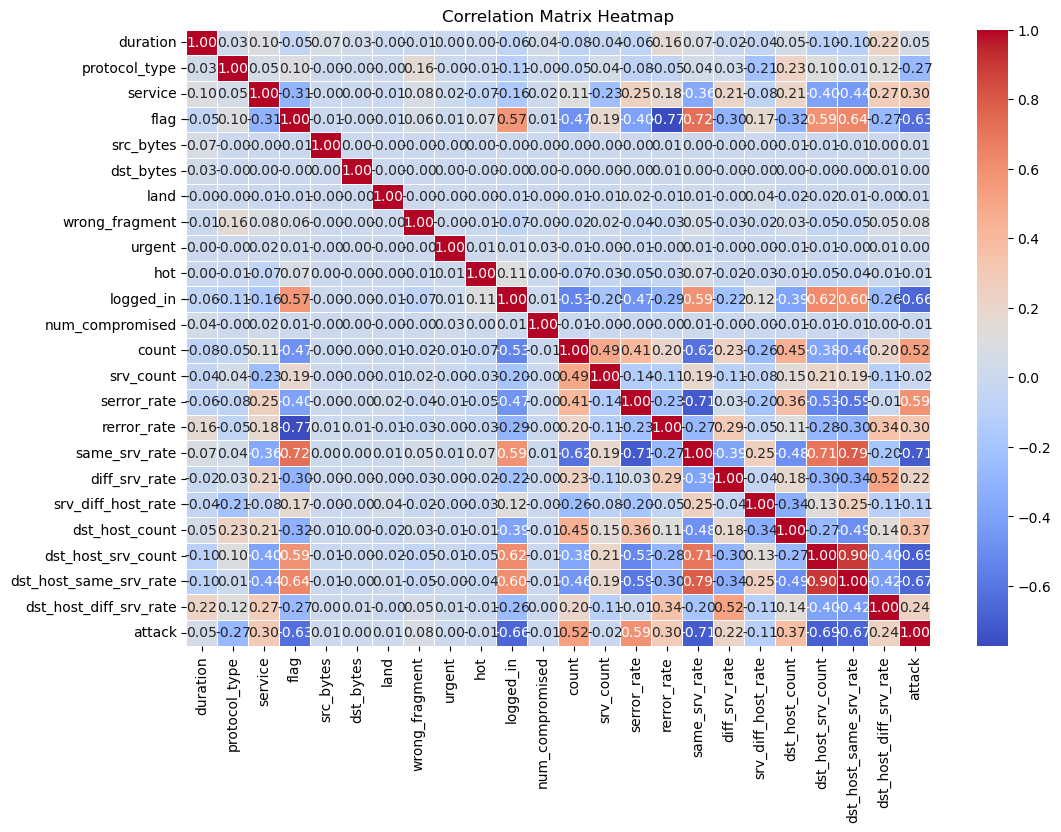

In [6]:
# Calculate the correlation matrix
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))

# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

⬆️
The correlation matrix highlights important relationships between the features in my dataset, providing insights into potential adjustments that could enhance model performance. Here’s what I found and the changes I plan to implement:

**Strong Correlations**:

Some feature pairs show high correlations, with values close to +1 or -1. For example, srv_count and same_srv_rate have a strong positive correlation. This suggests that these features are closely related and may be providing overlapping information.
Similarly, dst_host_same_srv_rate and dst_host_srv_count are highly correlated, which could indicate redundancy in the dataset.
Weak or No Correlation:

Some features, such as duration and land, show very low correlations with other features. This lack of correlation may imply that they don't have a significant linear relationship with other variables and might not contribute much to prediction accuracy.

**Target Feature (attack)**:

The attack column shows moderate positive correlations with some features, such as same_srv_rate and dst_host_same_srv_rate, suggesting that these features may provide useful information for distinguishing between classes in the target variable.

**Planned Adjustments**

**Feature Engineering**:

As an alternative to simply removing redundant features, I could explore creating new features that combine related information. For instance, combining srv_count and same_srv_rate could capture relevant behavior in a simplified way.

**Assessing Feature Importance**:

I plan to evaluate feature importance using techniques like Recursive Feature Elimination (RFE) or tree-based feature importance analysis. This would help confirm which features are essential for predicting attack and guide me in further refining the dataset.

**PCA for Dimensionality Reduction**:

Given the correlations observed, applying Principal Component Analysis (PCA) could be beneficial. PCA will help condense the feature space, capturing key variance while combining correlated features. This could reduce computational costs and potentially improve the model's generalization ability.
These adjustments, based on insights from the correlation matrix, aim to create a streamlined dataset that should improve model efficiency and effectiveness while minimizing redundancy.

**Eliminate overlapping data:Z-score⬇️**

In [27]:
# Use of Z-score
z_scores = np.abs(zscore(df))
threshold = 5
data_zscore = df[(z_scores < threshold).all(axis=1)]

# Compare Data
print(f"Original data size: {df.shape[0]}")
print(f"Data size after Z-score filtering: {data_zscore.shape[0]}")

Original data size: 148517
Data size after Z-score filtering: 143396


⬆️The datset has outliers, so it's necessary to remove these values, which can mislead the model. However, some attacks generate large amounts of data (such as brutforce attacks) and it would be a pity to remove this data. I therefore make sure to delete only the most outliers with threshold=4.

_This may be a change that adversely affects the quality of the model; if the model results are not good, this elimination of overlapping can be corrected._

As we can see in the data statiscics from the beginning, the features do not have the same scales. 

2️⃣**Normalization.⬇️** 

In [28]:
# Idendity colomns
encoded_columns = ['protocol_type', 'service', 'flag', 'attack']
numeric_columns = [col for col in data_zscore.columns if col not in encoded_columns]

scaler = StandardScaler()
data_normalized = data_zscore.copy()

# Normalize only numericlas values
data_normalized[numeric_columns] = scaler.fit_transform(data_zscore[numeric_columns])

print(data_normalized.describe())

           duration  protocol_type        service           flag  \
count  1.433960e+05  143396.000000  143396.000000  143396.000000   
mean  -1.585635e-18       1.060169      31.741478       6.921121   
std    1.000003e+00       0.401546      16.279999       2.792408   
min   -1.207196e-01       0.000000       0.000000       0.000000   
25%   -1.207196e-01       1.000000      20.000000       5.000000   
50%   -1.207196e-01       1.000000      24.000000       9.000000   
75%   -1.207196e-01       1.000000      49.000000       9.000000   
max    1.545020e+01       2.000000      69.000000      10.000000   

          src_bytes     dst_bytes      land  wrong_fragment    urgent  \
count  1.433960e+05  1.433960e+05  143396.0    1.433960e+05  143396.0   
mean  -1.211524e-17  5.946130e-19       0.0   -8.027276e-18       0.0   
std    1.000003e+00  1.000003e+00       0.0    1.000003e+00       0.0   
min   -4.640327e-02 -4.193560e-02       0.0   -4.270191e-02       0.0   
25%   -4.640327e-02 -4

⬆️We can see now that the numerics values (note the ones that have been encoded) have been normalized and have a mean on the same scale.
I compared the correlation matrix of the initial dataset and the normalized dataset. We have almost the same results. This is a good sign, because it means that we haven't altered the direction of the variables, but now the features will have equivalent weight for the prediction model. 

**We split the data for the ML models⬇️**

In [29]:
# Split Data, features and target
X = data_normalized.drop(columns=['attack']) 
y = data_normalized['attack']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the sizes
print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 114716
Test set size: 28680


3️⃣**Implementation of the RFE⬇️**

In [ ]:
model_RFE = LogisticRegression(max_iter=1000)

# Perform RFE
rfe = RFE(estimator=model_RFE, n_features_to_select=10)
rfe.fit(X, y)

# Get the selected features
selected_features = X.columns[rfe.support_]
print("Selected features:", selected_features)

X_RFE = X[selected_features]
X_train_RFE, X_test_RFE, y_train, y_test = train_test_split(X_RFE, y, test_size=0.2, random_state=42)

# Optional: Display ranking of all features
print("Feature ranking:", rfe.ranking_)
print(X.columns)


Selected features: Index(['protocol_type', 'logged_in', 'count', 'srv_count', 'serror_rate',
       'rerror_rate', 'same_srv_rate', 'dst_host_count', 'dst_host_srv_count',
       'dst_host_same_srv_rate'],
      dtype='object')
Feature ranking: [10  1  9  3  8 12 13  7 14  4  1 11  1  1  1  1  1  5  6  1  1  1  2]
Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'logged_in',
       'num_compromised', 'count', 'srv_count', 'serror_rate', 'rerror_rate',
       'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
       'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate'],
      dtype='object')


⬆️ The RFE allows me to observe the 10 most important features in our model. I've chosen 10 because it seems a suitable number in proportion to the number of rows in the dataset. The great thing about RFE is that it keeps the features, so you understand the values it brings out. I created an copy of the data but with the RFE applied, so we will compare if the RFE is benefic or not.

**Non Implementation of the PCA⬇️**

I chose not to implement the PCA because the new features it creates “don't make sense”. However, in my project to create an IDS, it's very important that throughout my project I can understand what the signs of an attack are.

**Fonction to evaluate the models :⬇️**

In [30]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    result = f"Results for {model} are : accuracy = {accuracy} | precision : {precision} | recall : {recall} | f1 : {f1}"

    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {model}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    return accuracy, precision, recall, f1, result



⬆️I created this function so that I could quickly assess the effectiveness of a model. I may add other evaluation criteria in the future. 

**Fonction to create the ROC curve⬇️**

In [12]:
def plot_roc_curve(model, X_test, y_test, title=""):
    y_pred_proba = model.predict_proba(X_test)[:, 1] 
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {title}')
    plt.legend(loc="lower right")
    plt.show()

**TEST FONCTIONS🎰**

_Linear regression_

Logistic Regression without RFE:


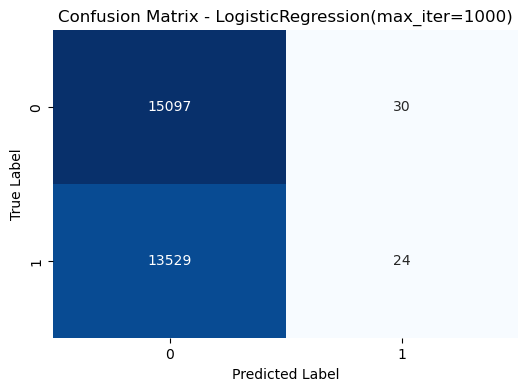

Results for LogisticRegression(max_iter=1000) are : accuracy = 0.527231520223152 | precision : 0.48819208977751616 | recall : 0.527231520223152 | f1 : 0.36565450214736117


In [37]:
# 1.A Logistic Regression
print("Logistic Regression without RFE:")
log_reg = LogisticRegression(max_iter=1000)
print(evaluate_model(log_reg, X_train, X_test, y_train, y_test)[4])


Logistic Regression with RFE:


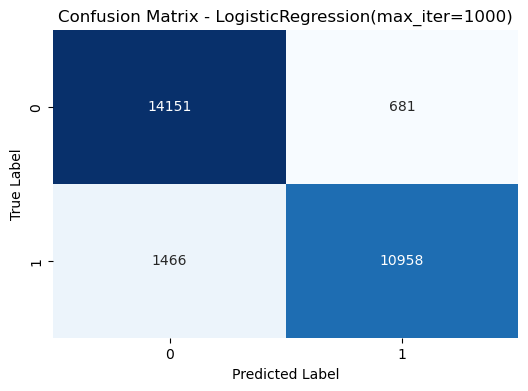

Results for LogisticRegression(max_iter=1000) are : accuracy = 0.9212283533900792 | precision : 0.9222468108581238 | recall : 0.9212283533900792 | f1 : 0.9209588801191814


In [14]:
# 1.B Logistic Regression with RFE
print("Logistic Regression with RFE:")
print(evaluate_model(log_reg, X_train_RFE, X_test_RFE, y_train, y_test)[4])
